In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as img
import math
from scipy import signal
import scipy.ndimage as ndi

## Histogram Equalization

Text(0.5, 1.0, 'Original Image')

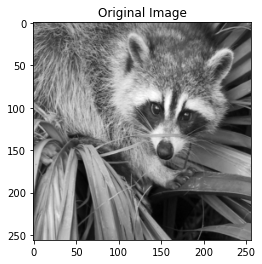

In [2]:
x = img.imread('./X.png')
plt.imshow(x, cmap="gray")
plt.title("Original Image")

### Histogram equalization

#### Get histogram

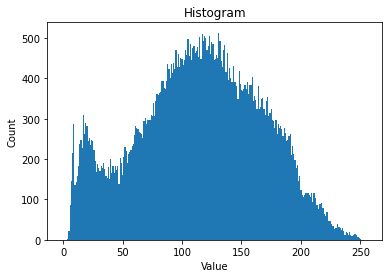

In [3]:
def histogram(x, L = 256):
    hist, _ = np.histogram(x, bins=L, range=(0, 1))
    bins = np.arange(L)
    return hist, bins
    
hist, bins = histogram(x, 256)
plt.bar(bins, hist, width = 1)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

#### Normalize histogram

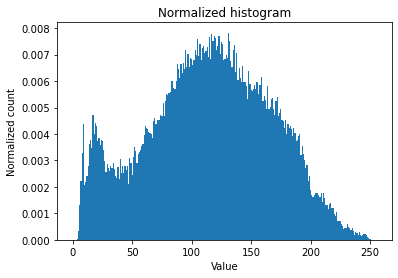

In [4]:
def normalized_histogram(x, N):
    hist, bins = histogram(x,N)
    norm_hist = hist/len(x.flatten())
    return norm_hist, bins

hist, bins = normalized_histogram(x, 256)

plt.bar(bins, hist, width = 1)
plt.title("Normalized histogram")
plt.xlabel("Value")
plt.ylabel("Normalized count")
plt.show()

#### Equalize histogram

Text(0.5, 1.0, 'Contrast curve, Equalized Histogram')

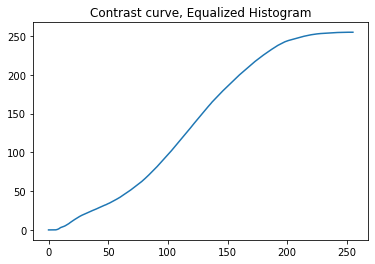

In [5]:
# create our cumulative sum 
def equalize(hist):
    result = []
    for i in range(len(hist)):
        partial_sum = 0.0
        for j in range(i):
            partial_sum+=hist[j]
        result.append(partial_sum)
    return 255 * np.array(result)

eq_hist = equalize(hist)
plt.plot(eq_hist)
plt.title("Contrast curve, Equalized Histogram")

#### Transform image

In [6]:
def apply_eq(x):
    hist, _ = normalized_histogram(x, 256)
    eq = equalize(hist)
    new = []
    for value in x.flatten(): new.append(eq[int(value*255)])
    new = np.array(new)
    x_new = np.reshape(new, x.shape)
    return x_new

Text(0.5, 1.0, 'Image with equalization')

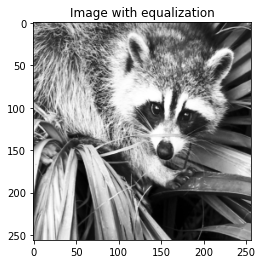

In [7]:
x_new = apply_eq(x)
plt.imshow(x_new, cmap="gray")
plt.title("Image with equalization")

### Exact histogram equalization

(Coltuc, Dinu, Philippe Bolon, and J-M. Chassery. ”Exact histogram specification.” IEEE Transactions on Image Processing 15.5, 2016).

#### Define filters

In [8]:
h1 = np.array([[1]])
h2 = (1/5) * np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]])
h3 = (1/9) * np.ones((3,3))
h4 = (1/13) * np.array([[0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0]])
h5 = (1/21) * np.array([[0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0]])
h6 = (1/25) * np.ones((5,5))
H = [h1, h2, h3, h4, h5, h6]

#### Get exact histogram equalization

In [9]:
 def apply_exact_eq(image, filters):
    
    K = len(filters) # Number of filters applied
    L = 256 # Number of gray levels
    MN = image.shape[0] * image.shape[1] # 1D image size
    
    # Create working matrix to keep track of indices and recover the image order 
    # Column 1: Pixel value
    # Column 2: Pixel index
    # Column 3-8: ak(m, n) pixel average intensity K-tuple
    working_matrix = np.ones((MN, K + 2))

    # Image pixel values
    pixel_values = image.flatten()
    working_matrix[:, 0] = pixel_values
    
    # Image pixel indices
    pixel_indices = np.arange(MN)
    working_matrix[:, 1] = pixel_indices
    
    # Average intensity value
    # Apply the filter and flatten the resulting image as 1D array 
    A_mn = np.array([ndi.convolve(image, h).flatten() for h in filters]) 
    working_matrix[:,2:K + 2] = A_mn.T

    # Order pixels lexographically
    lex_ordered_indices = np.lexsort(np.rot90(working_matrix))
    working_matrix = working_matrix[lex_ordered_indices]

    # Assign intensity value
    start = 0
    for j in range(0, L): # Split ordered pixels into L groups
        end = start + L
        working_matrix[start:end, 0] = j # Assign intensity value j to pixels in group j
        start = end

    # Sort using original 1D image order
    pixel_indices = working_matrix[:, 1]
    ordered_indices = pixel_indices.argsort()
    working_matrix = working_matrix[ordered_indices]
    
    # Reshape into 2D image form
    pixel_values = working_matrix[:, 0]
    new_x = pixel_values.reshape(image.shape)
    
    #Get histogram
    hist = np.zeros(L)
    for value in range(0, L): hist[value] = len(new_x[new_x == value])
    bins = np.arange(L)
    
    return new_x, hist, bins

Text(0.5, 1.0, 'Image with exact equalization')

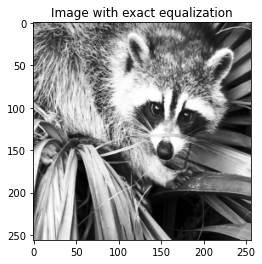

In [10]:
x_new, hist, bins = apply_exact_eq(x, H)
plt.imshow(x_new, cmap="gray")
plt.title("Image with exact equalization")

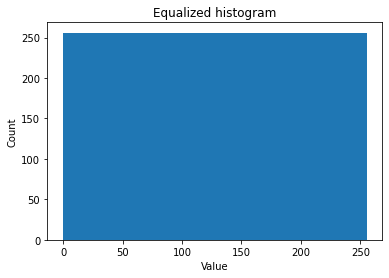

In [11]:
plt.bar(bins, hist, width = 1)
plt.title("Equalized histogram")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()